# FEV vs. Semanticity Analysis

For each SimCLR layer, this notebook plots **mean FEV** vs. **silhouette score**.

- **Mean FEV** is taken from the regression: SimCLR features (reduced to N PCs) → PC1 Neural data

- For each layer, we select the **best FEV** (i.e., highest across PC counts)
  
- Silhouette score is calculated from TSNE-transformed, PCA-reduced SimCLR features. The number of PCs used is normalised across layers

- SimCLR features are extracted from 1,000 images from the STL10 dataset (10 classes, 100 images per class)

In [1]:
from cortexlib.stl10 import STL10FewShotDataset
from cortexlib.simclr import PreTrainedSimCLRModel
from cortexlib.tsne import TSNEVisualizer
from cortexlib.utils import file as futils
from cortexlib.utils.plotting import simclr_colours
from cortexlib.utils.logging import Logger
import matplotlib.pyplot as plt
from adjustText import adjust_text
import pandas as pd

logger = Logger()

In [2]:
MOUSE_ID = futils.get_mouse_id()
logger.info(f"This notebook is running for mouse {MOUSE_ID}")

16:33:20 | INFO     | ℹ️ This notebook is running for mouse m03_d4


In [3]:
# For each layer, results has an FEV score for predicting neural data from SimCLR features reduced to N PCs
# Load results and filter the best FEV per layer (e.g. feats reduced to optimal number of PCs)
results = futils.read_json_file_as_dataframe('./prediction.json')
best_fev_per_layer = results.loc[results.groupby("layer")["mean_fev"].idxmax()]

best_fev_per_layer

,layer,n_pcs,test_r2,mean_fev
44,fc,500.0,0.409375,0.432509
1,layer1,10.0,0.383644,0.405533
11,layer2,20.0,0.460465,0.486069
21,layer3,50.0,0.462741,0.488455
34,layer4,400.0,0.431894,0.456116


In [4]:
simclr = PreTrainedSimCLRModel()

settings = simclr.get_image_settings()

logger.progress("Loading STL10 images")
stl10 = STL10FewShotDataset(
    n_per_class=100,
    size=settings['size'],
    channels=settings['channels'],
    normalise_mean=settings['mean'], 
    normalise_std=settings['std'],
)
logger.success("Loaded STL10 images")

16:33:20 | INFO     | ℹ️ Already downloaded pretrained SimCLR model
16:33:20 | INFO     | ⏳ Loading STL10 images...


Files already downloaded and verified
Files already downloaded and verified


16:33:33 | SUCCESS  | ✅ Loaded STL10 images!


In [5]:
logger.progress("SimCLR: extracting features from STL10 images")
simclr_feats, labels = simclr.extract_features(stl10.dataset)
logger.success("STL10 features extracted by SimCLR")

16:33:33 | INFO     | ⏳ SimCLR: extracting features from STL10 images...


  0%|          | 0/16 [00:00<?, ?it/s]

16:33:44 | SUCCESS  | ✅ STL10 features extracted by SimCLR!


In [6]:
# Map each label to its corresponding class name
class_labels = [stl10.class_names[label] for label in labels]

tsne_visualiser = TSNEVisualizer()
semanticity_results = []

logger.progress("Computing TSNE features from SimCLR features")
for n_pcs in [10, 20, 50, 100, 200, 300, 400, 500]:
    logger.info(f"{n_pcs} PCs")
    
    tsne_feats = tsne_visualiser.compute_tsne(simclr_feats, n_pca_components=n_pcs)
    silhouette_scores = tsne_visualiser.compute_silhouette_scores(tsne_feats, class_labels)

    for layer, score in silhouette_scores.items():
        semanticity_results.append({
            'layer': layer,
            'n_pcs': n_pcs,
            'silhouette_score': float(score) # json.dump() cannot serialize NumPy float32 types; convert to native Python floats first
        })

logger.success("TSNE features computed")

16:33:44 | INFO     | ⏳ Computing TSNE features from SimCLR features...
16:33:44 | INFO     | ℹ️ 10 PCs
16:33:58 | INFO     | ℹ️ 20 PCs
16:34:13 | INFO     | ℹ️ 50 PCs
16:34:31 | INFO     | ℹ️ 100 PCs
16:34:47 | INFO     | ℹ️ 200 PCs
16:35:06 | INFO     | ℹ️ 300 PCs
16:35:28 | INFO     | ℹ️ 400 PCs
16:35:51 | INFO     | ℹ️ 500 PCs
16:36:18 | SUCCESS  | ✅ TSNE features computed!


In [7]:
semanticity_results_df = pd.DataFrame(semanticity_results)
semanticity_results_df.head(12)

,layer,n_pcs,silhouette_score
0,layer1,10,-0.088655
1,layer2,10,-0.095839
2,layer3,10,-0.015531
3,layer4,10,0.058731
4,fc,10,0.091639
5,layer1,20,-0.113132
6,layer2,20,-0.089764
7,layer3,20,-0.027599
8,layer4,20,0.084575
9,fc,20,0.092164


In [8]:
futils.write_json_file(semanticity_results, './semanticity.json')

In [9]:
# The dimensionality of features varies across model layers, so normalise it by the number of PCs used
semanticity_pcs = semanticity_results_df[semanticity_results_df['n_pcs'] == 100].reset_index(drop=True)
semanticity_pcs

,layer,n_pcs,silhouette_score
0,layer1,100,-0.114038
1,layer2,100,-0.080252
2,layer3,100,-0.005445
3,layer4,100,0.085083
4,fc,100,0.107564


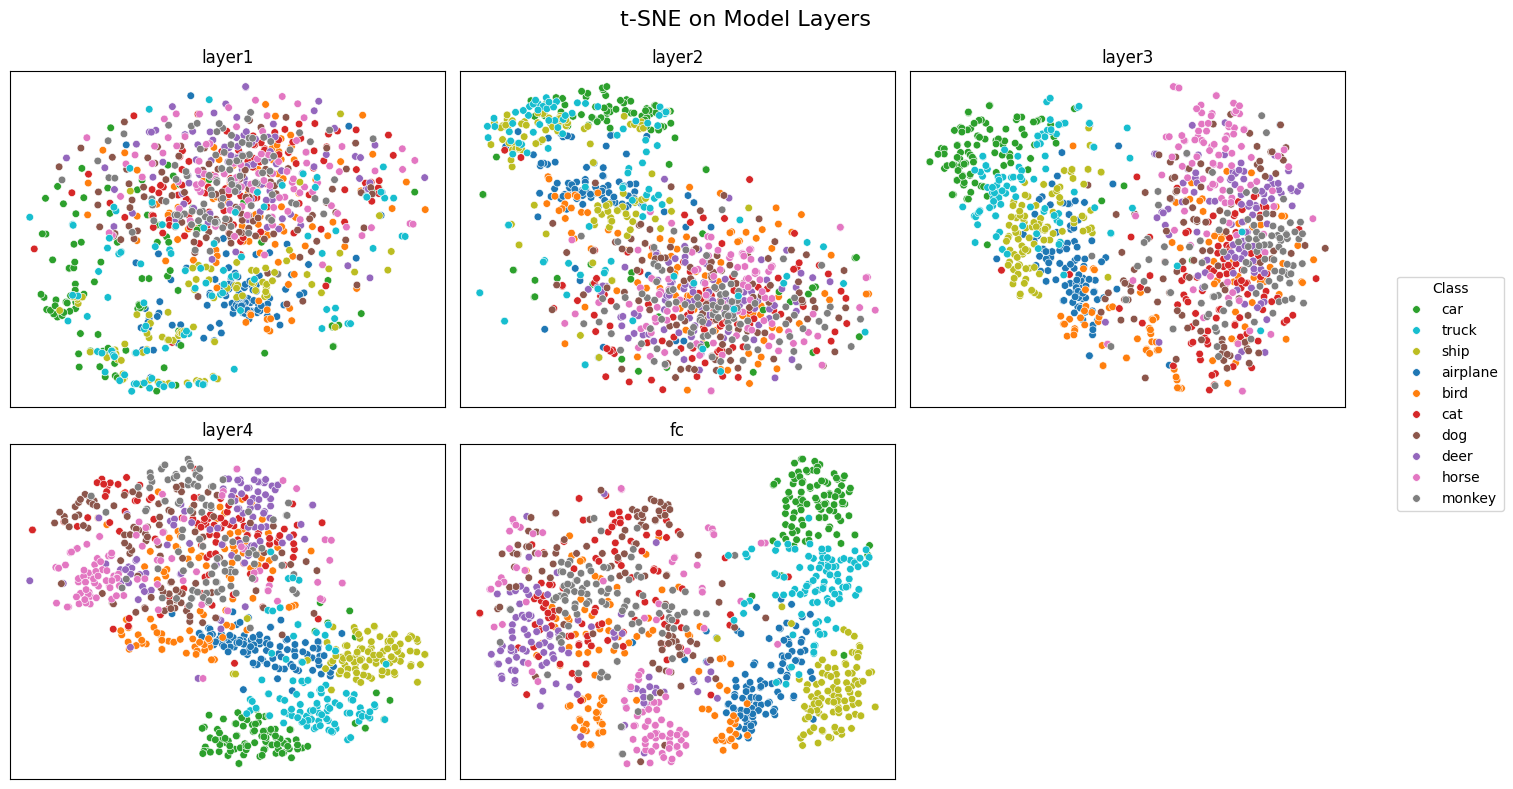

In [10]:
ordered_class_names = ['car', 'truck', 'ship', 'airplane', 'bird', 'cat',
                       'dog', 'deer', 'horse', 'monkey']

tsne_visualiser.plot_clusters_all_layers(tsne_feats, class_labels, custom_legend_order=ordered_class_names)

In [11]:
merged_results = pd.merge(best_fev_per_layer, semanticity_pcs, on='layer')
merged_results

,layer,n_pcs_x,test_r2,mean_fev,n_pcs_y,silhouette_score
0,fc,500.0,0.409375,0.432509,100,0.107564
1,layer1,10.0,0.383644,0.405533,100,-0.114038
2,layer2,20.0,0.460465,0.486069,100,-0.080252
3,layer3,50.0,0.462741,0.488455,100,-0.005445
4,layer4,400.0,0.431894,0.456116,100,0.085083


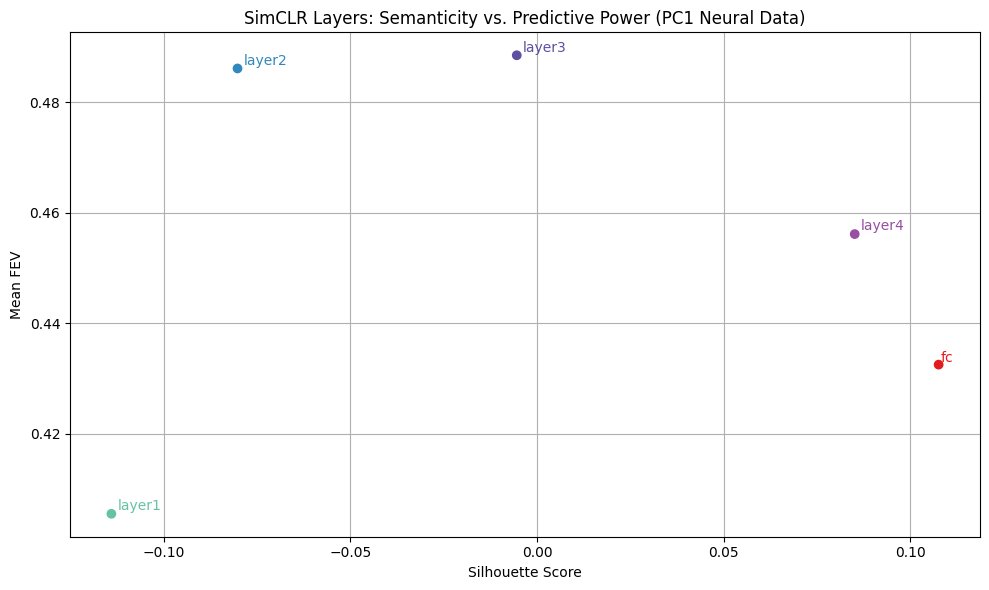

In [12]:
colours = merged_results['layer'].map(simclr_colours)

plt.figure(figsize=(10, 6))
plt.scatter(merged_results['silhouette_score'], merged_results['mean_fev'], c=colours)

texts = []
for _, row in merged_results.iterrows():
    texts.append(
        plt.text(row['silhouette_score'], row['mean_fev'], row['layer'],
                 color=simclr_colours[row['layer']], fontsize=10)
    )

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))

plt.xlabel('Silhouette Score')
plt.ylabel('Mean FEV')
plt.title('SimCLR Layers: Semanticity vs. Predictive Power (PC1 Neural Data)')
plt.grid(True)
plt.tight_layout()
plt.show()